In [1]:
!git clone https://github.com/ARBML/Calliar
%cd Calliar

Cloning into 'Calliar'...
remote: Enumerating objects: 2263, done.
remote: Counting objects: 100% (187/187), done.
remote: Compressing objects: 100% (78/78), done.
remote: Total 2263 (delta 101), reused 172 (delta 101), pack-reused 2076 (from 1)
Receiving objects: 100% (2263/2263), 247.86 MiB | 32.46 MiB/s, done.
Resolving deltas: 100% (557/557), done.
/content/Calliar


In [2]:
!pip install -r requirements.txt
!unzip calliar_dataset/dataset.zip

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.8 MB/s eta 0:00:00
  Created wheel for rdp: filename=rdp-0.8-py3-none-any.whl size=4585 sha256=f804679cfd78eb72369f5ad4ed5aa1f146a798f9145463764da20705a46ed88a
  Stored in directory: /root/.cache/pip/wheels/3e/80/75/e2f0e8372fde60e3be87cc64b088e10b6ed78589719d69653e
Successfully built rdp
Archive:  calliar_dataset/dataset.zip
   creating: pix2pix/
   creating: pix2pix/test/
  inflating: pix2pix/test/Amira_أميرة.jpg  
  inflating: pix2pix/test/Dalia_داليا.jpg  
  inflating: pix2pix/test/Amela_أميلا.jpg  
  inflating: pix2pix/test/Jehan_جيهان.jpg  
  inflating: pix2pix/test/Stephanie_ستيفاني.jpg  
  inflating: pix2pix/test/Elaph_إيلاف.jpg  
  inflating: pix2pix

In [5]:
!unzip calligraphy_dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: text/sample_01659.txt   
  inflating: text/sample_01034.txt   
  inflating: text/sample_01260.txt   
  inflating: text/sample_00204.txt   
  inflating: text/sample_00297.txt   
  inflating: text/sample_00584.txt   
  inflating: text/sample_00560.txt   
  inflating: text/sample_01400.txt   
  inflating: text/sample_01342.txt   
  inflating: text/sample_00423.txt   
  inflating: text/sample_01678.txt   
  inflating: text/sample_01398.txt   
  inflating: text/sample_00709.txt   
  inflating: text/sample_00203.txt   
  inflating: text/sample_00146.txt   
  inflating: text/sample_00173.txt   
  inflating: text/sample_00819.txt   
  inflating: text/sample_01446.txt   
  inflating: text/sample_01003.txt   
  inflating: text/sample_01114.txt   
  inflating: text/sample_00334.txt   
  inflating: text/sample_00894.txt   
  inflating: text/sample_00180.txt   
  inflating: text/sample_01235.txt   
  inflating: text/sample_00776.txt   

In [6]:
import os
os.getcwd()

'/content/Calliar'

In [7]:
!ls

calliar_dataset		 dataset     LICENSE  notebooks  README.md	   text
calliar_server		 demo.ipynb  masks    page	 requirements.txt
calligraphy_dataset.zip  images      media    pix2pix	 scripts


In [3]:
pip install arabic-reshaper python-bidi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.6/300.6 kB 6.9 MB/s eta 0:00:00


In [4]:
pip install scikit-learn arabic-reshaper python-bidi

In [5]:
import io
import glob
import json
import base64
from scripts.vis import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Video

هذا من فضل ربي


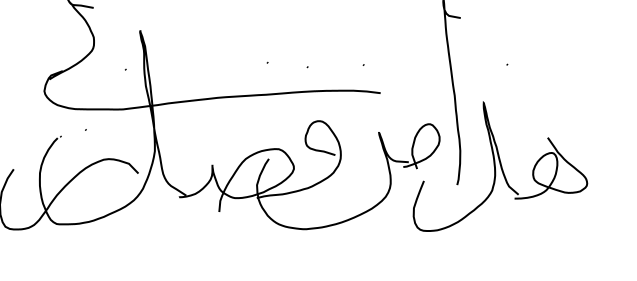

In [6]:
npy_files = glob.glob('dataset/train/**.json')
json_path = np.random.choice(npy_files)
drawing = json.load(open(json_path))
print(get_annotation(json_path))
data, _ = convert_3d(drawing, return_flag=True, threshold=50)
draw_strokes(data, stroke_width = 2, crop = True)


In [7]:
from sklearn.cluster import KMeans
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display


def is_dot(stroke):
    key = list(stroke.keys())[0]
    pts = stroke[key]
    return len(pts) <= 2  # small stroke → dot


def stroke_centroid(stroke):
    key = list(stroke.keys())[0]
    pts = stroke[key]
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    return np.mean(xs), np.mean(ys)


def horizontal_span(stroke):
    key = list(stroke.keys())[0]
    pts = stroke[key]
    xs = [p[0] for p in pts]
    return min(xs), max(xs)


def vertical_distance(dot, stroke):
    dx, dy = stroke_centroid(dot)
    sx, sy = stroke_centroid(stroke)
    return abs(dy - sy)


def group_strokes_by_text(drawing, text):
    reshaped = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped)
    K = len(display_text)

    # -------------------------
    # Separate dots vs main strokes
    # -------------------------
    long_strokes = []
    dot_strokes = []

    for st in drawing:
        (dot_strokes if is_dot(st) else long_strokes).append(st)

    # -------------------------
    # Cluster *only main strokes* into K means
    # -------------------------
    long_centroids = np.array([stroke_centroid(s) for s in long_strokes])

    # ---------- FIX: adjust K if needed ----------
    K = len(display_text)
    n_main = len(long_strokes)

    if n_main < K:
      # reduce cluster count to number of available main strokes
      # (Arabic letters often share a connected spine)
      print(f"[WARN] main strokes ({n_main}) < letters ({K}) → reducing K to {n_main}")
      K = n_main

    kmeans = KMeans(n_clusters=K, n_init=20, random_state=0)
    long_labels = kmeans.fit_predict(long_centroids)

    clusters = {i: [] for i in range(K)}

    for st, label in zip(long_strokes, long_labels):
        clusters[label].append(st)

    centers = kmeans.cluster_centers_

    # -------------------------
    # Sort clusters right→left visually
    # -------------------------
    sorted_cluster_ids = np.argsort(centers[:, 0])[::-1]

    # -------------------------
    # Build mapping char_index → cluster_id
    # -------------------------
    char_to_cluster = {char_i: sorted_cluster_ids[char_i]
                       for char_i in range(K)}

    # -------------------------
    # Assign dots with vertical-band matching
    # -------------------------
    for dot in dot_strokes:
        dx, dy = stroke_centroid(dot)
        best_char = None
        best_score = 999999

        for char_i in range(K):
            cid = char_to_cluster[char_i]
            strokes = clusters[cid]

            # find the stroke whose x-span overlaps the dot
            for s in strokes:
                minx, maxx = horizontal_span(s)
                if minx - 20 <= dx <= maxx + 20:   # allow some tolerance
                    d = vertical_distance(dot, s)
                    if d < best_score:
                        best_score = d
                        best_char = cid

        # fallback (if no overlap)
        if best_char is None:
            distances = [abs(dy - stroke_centroid(s)[1]) for s in long_strokes]
            best_char = np.argmin(distances)

        clusters[best_char].append(dot)

    # -------------------------
    # Build final grouped output
    # -------------------------
    grouped = []
    for char_i in range(K):
        cid = char_to_cluster[char_i]
        ch = display_text[char_i]
        grouped.append({ch: clusters[cid]})

    return grouped


In [8]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# Utility: generate N random RGB colors
# -------------------------------
def random_colors(n):
    return [np.random.rand(3,) for _ in range(n)]

# -------------------------------
# Drawing function: each letter gets a different color
# data = output from convert_3d()
# -------------------------------
def draw_multicolor_letters(data, stroke_width=2, crop=True):
    """
    data: list of letters, each containing list of strokes,
          and each stroke is a list of (x, y, t).
    """
    num_letters = len(data)
    colors = random_colors(num_letters)

    plt.figure(figsize=(4, 4))

    all_x = []
    all_y = []

    # Draw each letter using its own color
    for letter_idx, letter in enumerate(data):
        color = colors[letter_idx]

        for stroke in letter:
            x = [p[0] for p in stroke]
            y = [p[1] for p in stroke]

            all_x.extend(x)
            all_y.extend(y)

            plt.plot(x, y, linewidth=stroke_width, color=color)

    # Invert Y for visual correctness
    plt.gca().invert_yaxis()

    # Optional cropping
    if crop:
        plt.xlim(min(all_x), max(all_x))
        plt.ylim(max(all_y), min(all_y))

    plt.axis('off')
    plt.show()

Loaded: dataset/train/وماتوفيقي إلا بالله_0.json
وماتوفيقي إلا بالله


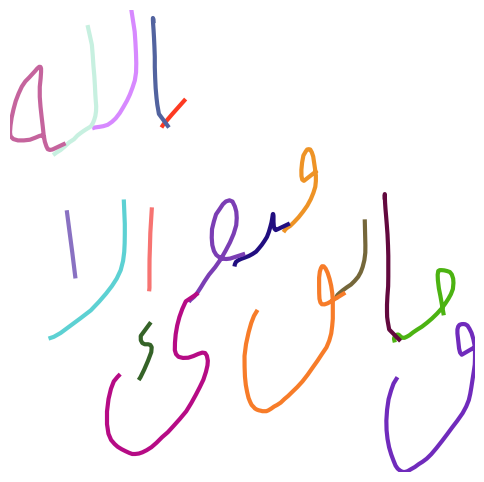

In [9]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
#   Draw letters with each letter in a different random color
# ============================================================
def draw_colored_letters(json_data, stroke_width=3, crop=True):

    plt.figure(figsize=(6, 6))

    all_x = []
    all_y = []

    num_letters = len(json_data)

    # assign one random color per letter
    colors = [np.random.rand(3,) for _ in range(num_letters)]

    for i, letter_dict in enumerate(json_data):

        # each item is:   { "letter": [[x,y], [x,y], ...] }
        letter = list(letter_dict.keys())[0]
        points = letter_dict[letter]

        if len(points) < 2:
            continue

        x = [p[0] for p in points]
        y = [p[1] for p in points]

        all_x.extend(x)
        all_y.extend(y)

        plt.plot(x, y, color=colors[i], linewidth=stroke_width)

    # correct orientation
    plt.gca().invert_yaxis()

    # crop tightly around the strokes
    if crop and all_x:
        plt.xlim(min(all_x), max(all_x))
        plt.ylim(max(all_y), min(all_y))

    plt.axis('off')
    plt.show()


# ============================================================
#        MAIN PIPELINE: load → draw multicolored
# ============================================================

# find all json files
json_files = glob.glob("dataset/train/**/*.json", recursive=True)

# pick one
json_path = np.random.choice(json_files)
print("Loaded:", json_path)
print(get_annotation(json_path))

# load json content
data = json.load(open(json_path))

# draw the multicolor version
draw_colored_letters(data, stroke_width=3, crop=True)


In [10]:
import os
import json

def save_pair_with_text(json_path, img_id):
    # Load drawing json
    drawing = json.load(open(json_path))

    # Extract text annotation
    text_label = get_annotation(json_path)

    # Generate BW + mask
    bw, mask = draw_bw_and_mask_fixed(drawing, text_label, stroke_width=8, scale=2)



    # --- Save images ----
    bw.save(f"calligraphy_dataset/images/{img_id}.png")
    mask.save(f"calligraphy_dataset/masks/{img_id}_mask.png")

    # --- Save text ----
    with open(f"calligraphy_dataset/text/{img_id}.txt", "w", encoding="utf8") as f:
        f.write(text_label)


In [11]:
# Import map_chars from Calliar/scripts/chars.py
import sys
from Calliar.scripts.chars import map_chars

from PIL import Image, ImageDraw
import numpy as np

def draw_bw_and_mask(drawing, stroke_width=8, scale=2):
    """
    Generates a black-and-white image and a colored mask from drawing data.

    drawing: list of dicts like [{"\u0621": [[x1, y1], ...]}, ...]
    stroke_width: thickness of strokes
    scale: image scaling factor
    """

    # -----------------------
    # Step 1: Group strokes by composite letter
    # -----------------------
    grouped = []
    i = 0
    while i < len(drawing):
        char = list(drawing[i].keys())[0]
        # check if this char is part of a composite
        composite_found = None
        for comp, parts in map_chars.items():
            if char in parts:
                composite_found = comp
                break

        if composite_found:
            num_parts = len(map_chars[composite_found])
            strokes = drawing[i:i+num_parts]
            grouped.append({composite_found: strokes})
            i += num_parts
        else:
            grouped.append({char: [drawing[i]]})
            i += 1

    # -----------------------
    # Step 2: Compute image size
    # -----------------------
    all_points = []
    for item in grouped:
        char = list(item.keys())[0]
        for stroke_item in item[char]:
            c = list(stroke_item.keys())[0]
            all_points += stroke_item[c]

    xs = [p[0] for p in all_points]
    ys = [p[1] for p in all_points]
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    W = int((max_x - min_x) * scale + 50)
    H = int((max_y - min_y) * scale + 50)

    # -----------------------
    # Step 3: Create images
    # -----------------------
    img_bw = Image.new("RGB", (W, H), "white")
    mask = Image.new("RGB", (W, H), "black")

    draw_bw = ImageDraw.Draw(img_bw)
    draw_mask = ImageDraw.Draw(mask)

    # assign a unique color per composite letter
    char_color = {list(item.keys())[0]: tuple(np.random.randint(40, 255, 3))
                  for item in grouped}

    # -----------------------
    # Step 4: Draw strokes
    # -----------------------
    for item in grouped:
        char = list(item.keys())[0]
        color = char_color[char]

        for stroke_item in item[char]:
            c = list(stroke_item.keys())[0]
            points = stroke_item[c]
            scaled = [((x - min_x) * scale, (y - min_y) * scale) for x, y in points]

            # if single point (dot), draw ellipse
            if len(scaled) <= 2:
                cx = np.mean([p[0] for p in scaled])
                cy = np.mean([p[1] for p in scaled])
                r = stroke_width
                draw_bw.ellipse((cx-r, cy-r, cx+r, cy+r), fill="black")
                draw_mask.ellipse((cx-r, cy-r, cx+r, cy+r), fill=color)
            else:
                draw_bw.line(scaled, fill="black", width=stroke_width)
                draw_mask.line(scaled, fill=color, width=stroke_width)

    return img_bw, mask


In [17]:
import glob
import os

json_files = glob.glob("dataset/train/**/*.json", recursive=True)

os.makedirs("calligraphy_dataset/images", exist_ok=True)
os.makedirs("calligraphy_dataset/masks", exist_ok=True)
os.makedirs("calligraphy_dataset/text", exist_ok=True)

for idx, js in enumerate(json_files):
    img_id = f"sample_{idx:05d}"
    save_pair_with_text(js, img_id)



In [12]:
from PIL import Image, ImageDraw
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

def group_strokes_by_text(drawing, text, scale=2):
    """
    Returns: list of {char: [stroke_dicts]}
    where each stroke dict is {"<component>": [(x,y), ...]}
    """

    # Normalize Arabic shaping (important!)
    reshaped = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped)  # right-to-left order

    # Compute stroke bounding boxes
    stroke_boxes = []
    for st in drawing:
        k = list(st.keys())[0]
        pts = st[k]
        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]
        stroke_boxes.append((k, st, np.mean(xs), np.mean(ys)))

    # Compute text-character x-centers using stroke ordering
    # The idea: characters generally get strokes near each other
    char_positions = np.linspace(0, 1, len(display_text))

    # Assign strokes to nearest character (R→L)
    groups = {i: [] for i in range(len(display_text))}

    for ch, st, cx, cy in stroke_boxes:
        # find best character index (right to left)
        # approximate horizontal position
        norm_x = cx / max([s[2] for s in stroke_boxes])
        idx = np.argmin(np.abs(char_positions - norm_x))
        groups[idx].append(st)

    # Convert groups to list
    grouped = []
    for i, ch in enumerate(display_text):
        grouped.append({ch: groups[i]})

    return grouped



def draw_bw_and_mask_fixed(drawing, text, stroke_width=8, scale=2):
    grouped = group_strokes_by_text(drawing, text)

    # ---- Collect all points for canvas size ----
    all_pts = []
    for item in grouped:
        ch = list(item.keys())[0]
        for st in item[ch]:
            k = list(st.keys())[0]
            all_pts += st[k]

    xs = [p[0] for p in all_pts]
    ys = [p[1] for p in all_pts]

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)

    W = int((max_x - min_x) * scale + 50)
    H = int((max_y - min_y) * scale + 50)

    img_bw = Image.new("RGB", (W, H), "white")
    mask = Image.new("RGB", (W, H), "black")

    draw_bw = ImageDraw.Draw(img_bw)
    draw_mask = ImageDraw.Draw(mask)

    # unique color per final character
    char_colors = {list(item.keys())[0]: tuple(np.random.randint(60,255,3)) for item in grouped}

    # ---- Draw strokes ----
    for item in grouped:
        ch = list(item.keys())[0]
        color = char_colors[ch]

        for st in item[ch]:
            k = list(st.keys())[0]
            pts = st[k]
            scaled = [((x - min_x) * scale, (y - min_y) * scale) for x,y in pts]

            if len(scaled) <= 2:
                cx = np.mean([p[0] for p in scaled])
                cy = np.mean([p[1] for p in scaled])
                r = stroke_width
                draw_bw.ellipse((cx-r, cy-r, cx+r, cy+r), fill="black")
                draw_mask.ellipse((cx-r, cy-r, cx+r, cy+r), fill=color)
            else:
                draw_bw.line(scaled, fill="black", width=stroke_width)
                draw_mask.line(scaled, fill=color, width=stroke_width)

    return img_bw, mask


In [16]:
from sklearn.cluster import KMeans
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display

def group_strokes_by_text(drawing, text):
    """
    Groups strokes into N clusters using K-means clustering.
    N = number of final shaped Arabic characters.

    Fixes incorrect grouping when letters visually overlap
    (common in calligraphy: e.g., 'جومانا', 'سبحان الله', etc.)
    """

    # --- Arabic shaping and RTL ordering ---
    reshaped = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped)  # RTL final sequence

    # --- Collect stroke centroids ---
    centroids = []
    strokes = []

    for st in drawing:
        key = list(st.keys())[0]
        pts = st[key]

        xs = [p[0] for p in pts]
        ys = [p[1] for p in pts]

        cx, cy = np.mean(xs), np.mean(ys)

        centroids.append([cx, cy])
        strokes.append(st)

    centroids = np.array(centroids)
    K = len(display_text)

    # --- K-means to cluster strokes by actual physical location ---
    kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
    labels = kmeans.fit_predict(centroids)

    # group strokes by cluster index
    clusters = {i: [] for i in range(K)}
    for st, label in zip(strokes, labels):
        clusters[label].append(st)

    # --- Sort clusters from rightmost to leftmost ---
    # Because Arabic characters proceed RTL in final rendered form
    cluster_centers = kmeans.cluster_centers_[:, 0]  # x-coordinates
    sorted_cluster_ids = np.argsort(cluster_centers)[::-1]  # RTL order

    # --- Assign characters to clusters in RTL order ---
    grouped = []
    for char_i, cluster_id in enumerate(sorted_cluster_ids):
        ch = display_text[char_i]
        grouped.append({ch: clusters[cluster_id]})

    return grouped


In [14]:
from sklearn.cluster import KMeans
import numpy as np
import arabic_reshaper
from bidi.algorithm import get_display


def is_dot(stroke):
    """Return True if stroke is only 1–2 points → likely a dot."""
    key = list(stroke.keys())[0]
    pts = stroke[key]
    return len(pts) <= 2


def stroke_centroid(stroke):
    key = list(stroke.keys())[0]
    pts = stroke[key]
    xs = [p[0] for p in pts]
    ys = [p[1] for p in pts]
    return np.mean(xs), np.mean(ys)


def group_strokes_by_text(drawing, text):
    """
    Improved grouping that:
    1) Clusters main strokes using K-Means
    2) Assigns dots to the nearest main-stroke cluster
    """

    # --- Arabic shaping + RTL ordering ---
    reshaped = arabic_reshaper.reshape(text)
    display_text = get_display(reshaped)
    K = len(display_text)

    # --- Separate dots from long strokes ---
    long_strokes = []
    dot_strokes = []

    for st in drawing:
        (dot_strokes if is_dot(st) else long_strokes).append(st)

    # --- Compute centroids for long strokes ---
    long_centroids = np.array([stroke_centroid(s) for s in long_strokes])

    # If all strokes are tiny (unlikely but safe), fallback:
    if len(long_centroids) < K:
        long_strokes = drawing
        dot_strokes = []

        long_centroids = np.array([stroke_centroid(s) for s in long_strokes])

    # --- K-Means on long strokes ---
    kmeans = KMeans(n_clusters=K, n_init=20, random_state=42)
    long_labels = kmeans.fit_predict(long_centroids)

    clusters = {i: [] for i in range(K)}

    # assign long strokes to clusters
    for st, label in zip(long_strokes, long_labels):
        clusters[label].append(st)

    # --- Assign dots to nearest cluster centroid ---
    centers = kmeans.cluster_centers_
    for dot in dot_strokes:
        cx, cy = stroke_centroid(dot)
        distances = np.sum((centers - np.array([cx, cy]))**2, axis=1)
        best_cluster = np.argmin(distances)
        clusters[best_cluster].append(dot)

    # --- Sort clusters right→left ---
    sorted_cluster_ids = np.argsort(centers[:, 0])[::-1]

    # --- Build final grouped list ---
    grouped = []
    for char_i, cluster_id in enumerate(sorted_cluster_ids):
        ch = display_text[char_i]
        grouped.append({ch: clusters[cluster_id]})

    return grouped


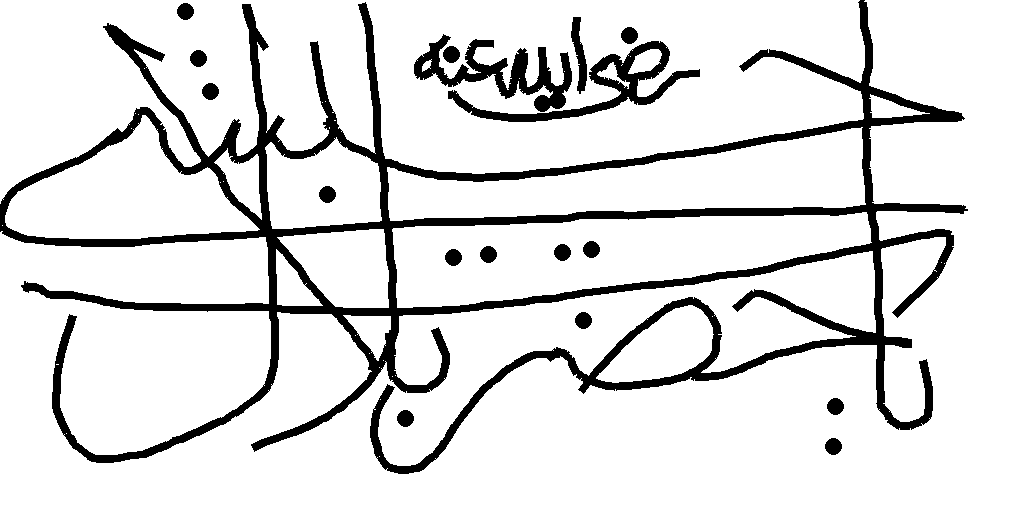

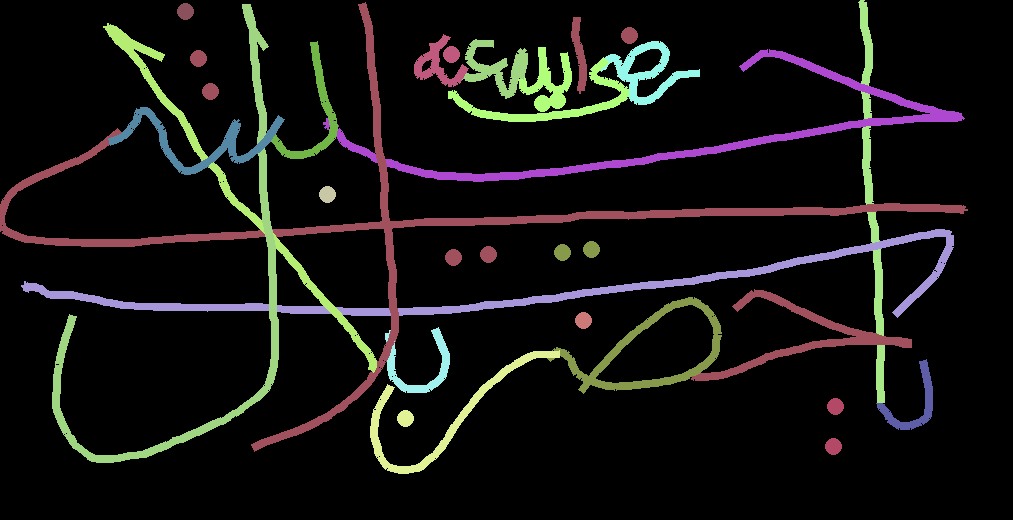

يا حضرت بلال حبشي رضي الله عنه


In [19]:
json_path = np.random.choice(npy_files)
drawing = json.load(open(json_path))

text = get_annotation(json_path)
bw, mask = draw_bw_and_mask_fixed(drawing,text)

bw.show()
mask.show()

bw.save("bw.png")
mask.save("mask.png")

display(bw)
display(mask)
print(text)

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.down1 = DoubleConv(3, 64)
        self.down2 = DoubleConv(64, 128)
        self.down3 = DoubleConv(128, 256)
        self.down4 = DoubleConv(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.out = nn.Conv2d(64, n_classes, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool(d1)

        d2 = self.down2(p1)
        p2 = self.pool(d2)

        d3 = self.down3(p2)
        p3 = self.pool(d3)

        d4 = self.down4(p3)
        p4 = self.pool(d4)

        mid = self.middle(p4)

        u4 = self.up4(mid)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.conv1(u1)

        return self.out(u1)



In [8]:
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
import os
import torch

class CalligraphyDataset(Dataset):
    def __init__(self, root):
        self.img_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")
        self.txt_dir = os.path.join(root, "text")

        self.files = sorted(os.listdir(self.img_dir))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        name = self.files[idx].split(".")[0]

        img = np.array(Image.open(f"{self.img_dir}/{name}.png").convert("RGB"))
        mask = np.array(Image.open(f"{self.mask_dir}/{name}.png").convert("RGB"))

        # convert RGB mask to integer class index map
        mask = mask[:, :, 0] * 256 * 256 + mask[:, :, 1] * 256 + mask[:, :, 2]

        # remap unique colors to class IDs
        uniques = np.unique(mask)
        mapping = {c: i for i, c in enumerate(uniques)}
        mask = np.vectorize(mapping.get)(mask)

        img = torch.tensor(img).permute(2,0,1).float() / 255.
        mask = torch.tensor(mask).long()

        return img, mask


In [25]:
from torch.utils.data import DataLoader
import torch.optim as optim
import numpy as np
import os
from PIL import Image

# ------------------------------
# Load dataset correctly
# ------------------------------
dataset = CalligraphyDataset("calligraphy_dataset")
loader = DataLoader(dataset, batch_size=4, shuffle=True)

# ------------------------------
# Compute number of classes
# ------------------------------
mask_dir = "calligraphy_dataset/masks"
colors = []

for f in os.listdir(mask_dir):
    path = os.path.join(mask_dir, f)
    mask = np.array(Image.open(path).convert("RGB"))

    # Flatten into RGB integer
    flat = mask[:,:,0].astype(np.int64) * 256 * 256 + mask[:,:,1].astype(np.int64) * 256 + mask[:,:,2].astype(np.int64)
    colors.append(np.unique(flat))

# all unique color IDs
unique_colors = np.unique(np.concatenate(colors))
n_classes = len(unique_colors)

print("Detected classes:", n_classes)

# ------------------------------
# Initialize model
# ------------------------------
model = UNet(n_classes).cuda()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

# ------------------------------
# Training Loop
# ------------------------------
for epoch in range(30):
    for img, mask in loader:
        img = img.cuda()
        mask = mask.cuda()

        pred = model(img)

        loss = criterion(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch} — Loss {loss.item():.4f}")



Detected classes: 13974


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [3]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

from torchvision import transforms

class CalligraphyDataset(Dataset):
    def __init__(self, root, img_size=(512,512)):
        self.img_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")
        self.files = sorted([f for f in os.listdir(self.img_dir) if f.endswith(".png")])
        self.transform_img = transforms.Compose([
            transforms.Resize(img_size),
            transforms.ToTensor()
        ])
        self.transform_mask = transforms.Compose([
            transforms.Resize(img_size, interpolation=Image.NEAREST)
        ])

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx]
        base_name = img_name.replace(".png", "")
        mask_name = f"{base_name}_mask.png"

        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        img = Image.open(img_path).convert("RGB")
        img = self.transform_img(img)  # tensor [3,H,W]

        mask = Image.open(mask_path).convert("RGB")
        mask = self.transform_mask(mask)
        mask = np.array(mask)
        mask = (mask[:,:,0].astype(np.int32) << 16) + \
               (mask[:,:,1].astype(np.int32) << 8) + \
               mask[:,:,2].astype(np.int32)
        mask = torch.tensor(mask).long()

        return img, mask


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, n_classes):
        super(UNet, self).__init__()

        def CBR(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 3, padding=1),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True)
            )

        self.enc1 = CBR(3, 64)
        self.enc2 = CBR(64, 128)
        self.enc3 = CBR(128, 256)
        self.enc4 = CBR(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = CBR(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = CBR(1024, 512)
        self.up3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = CBR(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = CBR(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = CBR(128, 64)

        self.final = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d4 = self.dec4(torch.cat([self.up4(b), e4], dim=1))
        d3 = self.dec3(torch.cat([self.up3(d4), e3], dim=1))
        d2 = self.dec2(torch.cat([self.up2(d3), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))

        return self.final(d1)


In [6]:
!ls

Calliar  sample_data


In [7]:
dataset = CalligraphyDataset("Calliar")

In [10]:


def compute_classes(dataset):
    all_classes = set()
    for _, mask in dataset:
        all_classes.update(torch.unique(mask).tolist())
    return len(all_classes)

n_classes = compute_classes(dataset)
print("Detected classes:", n_classes)


KeyboardInterrupt: 

Not supposed to have this many classes. If everything were correct, we would only have as many classes as there are letters.

In [8]:
import torch.optim as optim

device = "cpu"  # force CPU
model = UNet(n_classes).to(device)

loader = DataLoader(dataset, batch_size=2, shuffle=True)


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} — Loss: {total_loss/len(loader):.4f}")


NameError: name 'n_classes' is not defined

In [ ]:
# Example: accuracy per pixel
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for imgs, masks in loader:
        imgs, masks = imgs.to(device), masks.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)
        correct += (preds == masks).sum().item()
        total += masks.numel()

print("Pixel-wise accuracy:", correct/total)
